# Log analysis for DeepRacer

This notebook has been built based on the `DeepRacer Log Analysis.ipynb` provided by the AWS DeepRacer Team. It has been reorganised and expanded to provide new views on the training data without the helper code which was moved into utility `.py` files.

Apart from the install, you also have to configure your programmatic access to AWS. Have a look at the guides below, AWS resources will lead you by the hand:

AWS CLI: https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html

Boto Configuration: https://boto3.amazonaws.com/v1/documentation/api/latest/guide/configuration.html

## Imports

Run the imports block below

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

#Shapely Library
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

import track_utils as tu
import log_analysis as la
import cw_utils as cw

# Make sure your boto version is >= '1.9.133'
cw.boto3.__version__

'1.9.234'

This block below has been prepared in case you would like to make some changes to the utility code that comes with this notebook. It will reload track_utlis.py, log_analysis.py and cw_utils.py without the need to reload the notebook. In normal usage of the notebook you will not need it.

In [21]:
# reload log_analysis and the rest of stuff here if needed
# (handy for code updates in utils, doesn't break anything if no changes)
import importlib
importlib.reload(la)
importlib.reload(cw)
importlib.reload(tu)

<module 'track_utils' from '/Users/ryannazareth/Documents/AWS_Deepracer/log-analysis/track_utils.py'>

## Load waypoints for the track you want to run analysis on

The track waypoint files usually show up as new races start. Be sure to check for them in repository updates. You only need to load them in the block below.

These files represent the coordinates of characteristic points of the track - the center line, inside border and outside border. Their main purpose is to visualise the track in images below. One thing that you may want to remember is that at the moment not all functions below work with all values of the coordinates. Especially some look awkward with bigger tracks or with negative coordinates. Usually there is an explanation on what to do to fix the view.

The naming of the tracks is not super consistent. I'm also not sure all of them are available in the console or locally. You may want to know that:
* London_Loop and Virtual_May19_Train_track - are the AWS DeepRacer Virtual League London Loop tracks
* Tokyo - is the AWS DeepRacer Virtual League Kumo Torakku track
* New_York - are the AWS DeepRacer Virtual League Empire City training and evaluation tracks
* China - are the AWS Deepracer Virtual League Shanghai Sudu training and evaluation tracks
* reinvent_base - is the re:Invent 2019 racing track

There are also other tracks that you may want to explore. Each of them has its own properties that you might find useful for your model.

Remeber that evaluation npy files are a community effort to visualise the tracks in the trainings, they aren't 100% accurate.

Tracks Available:

In [22]:
!ls tracks/

AWS_track.npy                 Mexico_track_eval.npy
Bowtie_track.npy              New_York_Eval_Track.npy
Canada_Eval.npy               New_York_Track.npy
Canada_Training.npy           Oval_track.npy
China_eval_track.npy          Straight_track.npy
China_track.npy               Tokyo_Training_track.npy
H_track.npy                   Virtual_May19_Train_track.npy
London_Loop_Train.npy         reinvent_base.npy
Mexico_track.npy


Take the name from results above and paste below to load the key elements of the track and view the outline of it.

Loaded 203 waypoints


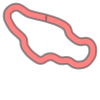

In [23]:
l_center_line, l_inner_border, l_outer_border, road_poly = tu.load_track("Canada_Training.npy")

road_poly

## Get the logs

Depending on which way you are training your model, you will need a different way to load the data.

**AWS DeepRacer Console**
The logs are being stored in CloudWatch, in group `/aws/robomaker/SimulationJobs`. You will be using boto3 to download them based on the training ID (stream name prefix). If you wish to bulk export the logs from Amazon Cloudwatch to Amazon S3 :: https://docs.aws.amazon.com/AmazonCloudWatch/latest/logs/S3ExportTasks.html


## Load the trace training log

Now that the data is downloaded, we need to load it into memory. We will first read it from file and then convert to data frames in Pandas. [Pandas](https://pandas.pydata.org/) is a Python library for handling and analysing large amounts of data series. Remember this name, you may want to learn more about how to use it to get more information that you would like to get from the logs. Examples below are hardly scratching the surface.

One important information to enter is the setting of your Episodes per iteration hyperparameter. This is used to group the episodes into iterations. This information is valuable when later looking at graphs showing how the training progresses per iteration. You can use it to detect which iteration gave you better outcomes and, if in local training, you could move to that iteration's outcome for submissions in the AWS DeepRacer League or  for continuing the training.

The log files you have just gathered above have lines like this one:
```
SIM_TRACE_LOG:799,111,1.7594,4.4353,3.0875,-0.26,2.50,2,1.0000,False,True,71.5802,49,17.67,1555554451.1110387
```
This is all that matters for us. The first two are some tests I believe and when loading they get skipped, then each next line has the following fields:
* episode number
* step number
* x coordinate
* y coordinate
* yaw of the car (where the car is heading)
* decision about turning (turn value from your action space)
* decision about throttle (speed value from your action space)
* decision index (value from your action space)
* reward value
* is the car going backwards
* are all wheels on track?
* progress in the lap
* closest waypoint
* track length
* timestamp

`la.load_data` and then `la.convert_to_pandas` read it and prepare for your usage. Sorting the values may not be needed, but I have experienced under some circumstances that the log lines were not ordered properly.

In [54]:
# AWS DeepRacer Console
stream_name = 'sim-wl89vfql0mhd' ## CHANGE This to your simulation application ID
fname = 'logs/deepracer-%s.log' %stream_name  # The log will be downloaded into the specified path
cw.download_log(fname, stream_prefix=stream_name, force=True)  # add force=True if you downloaded the file before but want to repeat


In [55]:
EPISODES_PER_ITERATION = 10 #  Set to value of your hyperparameter in training

data = la.load_data(fname)
df = la.convert_to_pandas(data, episodes_per_iteration=EPISODES_PER_ITERATION)

df = df.sort_values(['episode', 'steps'])
# personally I think normalizing can mask too high rewards so I am commenting it out,
# but you might want it.
# la.normalize_rewards(df)

#Uncomment the line of code below to evaluate a different reward function
#la.new_reward(df, l_center_line, 'reward.reward_sample') #, verbose=True)

In [56]:
data

['0,0,4.4741,1.6796,2.8768,0.00,0.00,0,0.2000,False,True,0.6437,1,21.74,1572135302.0218687\n',
 '0,1,4.4741,1.6796,2.8768,-0.52,1.50,0,0.2000,False,True,0.6437,1,21.74,1572135302.1007292\n',
 '0,0,4.4741,1.6797,2.8770,0.00,0.00,0,0.2000,False,True,0.6437,1,21.74,1572135314.6121829\n',
 '0,1,4.4741,1.6797,2.8773,-0.26,3.00,4,0.2000,False,True,0.6438,1,21.74,1572135314.7048228\n',
 '0,2,4.4678,1.6817,2.8746,0.00,1.50,6,0.2000,False,True,0.6743,1,21.74,1572135314.759483\n',
 '0,3,4.4503,1.6872,2.8697,0.00,4.50,8,0.2000,False,True,0.7584,2,21.74,1572135314.8078763\n',
 '0,4,4.4204,1.6973,2.8589,-0.26,4.50,5,0.2000,False,True,0.9031,2,21.74,1572135314.8811648\n',
 '0,5,4.3778,1.7128,2.8396,0.00,3.00,7,0.2000,False,True,1.1099,2,21.74,1572135314.9446476\n',
 '0,6,4.3223,1.7328,2.8246,0.00,1.50,6,0.2000,False,True,1.3797,3,21.74,1572135315.0153046\n',
 '0,7,4.2673,1.7537,2.8088,0.00,4.50,8,0.2000,False,True,1.6474,3,21.74,1572135315.0863407\n',
 '0,8,4.2065,1.7784,2.7867,-0.52,3.00,1,0.2000,F

## New reward

Note the last line above: it takes a reward class from log-analysis/rewards, imports it, instantiates and recalculates reward values based on the data from the log. This lets you do some testing before you start training and rule out some obvious things.

*If you find this confusing, don't worry, because it is confusing. You can safely ignore it for now and come back to it later.*

This operation is possible because the logs contain all information needed to recreate the params for a given step. That said some could be implemented better and some were ignored for now and should be implemented.

The sample reward mentioned in that line is located in `log-analysis/rewards/reward_sample.py` and looks like this:

```
from time import time


class Reward:
    def __init__(self, verbose=False):
        self.previous_steps = None
        self.initial_time = None
        self.verbose = verbose

    @staticmethod
    def get_time(params):
        # remember: this will not return time before
        # the first step has completed so the total
        # time for lap will be lower by about 0.2s
        return params.get('timestamp', None) or time()

    def reward_function(self, params):
        if self.previous_steps is None \
                or self.previous_steps > params['steps']:
            # new lap!
            self.initial_time = self.get_time(params)
        else:
            # we're continuing a lap
            pass

        steering_factor = 1.0

        if abs(params['steering_angle']) > 14:
            steering_factor = 0.7

        reward = float(steering_factor)

        self.previous_steps = params['steps']

        if self.verbose:
            print(params)

        return reward


reward_object = Reward()


def reward_function(params):
    return reward_object.reward_function(params)

```

After some imports a class is declared, it's called `Reward`, then the class is instantiated and a function `reward_function` is declared. This somewhat bloated structure has a couple benefits:
* It works in console/local training for actual training
* It lets you reload the definition for class Reward and retry the reward function multiple times after changes without much effort
* If you want to rely on state carried over between the steps, it's all contained in a reward object 

The reward class hides two or three tricks for you:
* `get_time` lets you abstract from machine time in log analysis - the supporting code adds one extra param, `timestamp`. That lets you get the right time value in new_reward function
* the first condition allows detecting the beginning of an episode or even start of training you can use it for some extra operations between the episodes
* `verbose` can be used to provide some noisier prints in the reward function - you can switch them on when loading the reward function above.

Just remember: not all params are provided, you are free to implement them and raise a Pull Request for log_analysis.df_to_params method.

If you just wrap your reward function like in the above example, you can use it in both log analysis notebook and the training.

Final warning: there is a loss of precision in the logs (rounded numbers) and also potentially potential bugs. If you find any, please fix, please report.

## Graphs

The original notebook has provided some great ideas on what could be visualised in the graphs. Below examples are a slightly extended version. Let's have a look at what they are presenting and what this may mean to your training.

### Training progress

As you have possibly noticed by now, training episodes are grouped into iterations and this notebook also reflects it. What also marks it are checkpoints in the training. After each iteration a set of ckpt files is generated - they contain outcomes of the training, then a model.pb file is built based on that and the car begins a new iteration. Looking at the data grouped by iterations may lead you to a conclusion, that some earlier checkpoint would be a better start for a new training. While this is limited in the AWS DeepRacer Console, with enough disk space you can keep all the checkpoints along the way and use one of them as a start for new training (or even as a submission to a race).

While the episodes in a given iteration are a mixture of decision process and random guesses, mean results per iteration may show a specific trend. Mean values are accompanied by standard deviation to show the concentration of values around the mean.

#### Rewards per Iteration

You can see these values as lines or dots per episode in the AWS DeepRacer console. When the reward goes up, this suggests that a car is learning and improving with regards to a given reward function. **This does not have to be a good thing.** If your reward function rewards something that harms performance, your car will learn to drive in a way that will make results worse.

At first the rewards just grow if the progress achieved grows. Interesting things may happen slightly later in the training:

* The reward may go flat at some level - it might mean that the car can't get any better. If you think you could still squeeze something better out of it, review the car's progress and consider updating the reward function, the action space, maybe hyperparameters, or perhaps starting over (either from scratch or from some previous checkpoint)
* The reward may become wobbly - here you will see it as a mesh of dots zig-zagging. It can be a gradually growing zig-zag or a roughly stagnated one. This usually means the learning rate hyperparameter is too high and the car started doing actions that oscilate around some local extreme. You can lower the learning rate and hope to step closer to the extreme. Or run away from it if you don't like it
* The reward plunges to near zero and stays roughly flat - I only had that when I messed up the hyperparameters or the reward function. Review recent changes and start training over or consider starting from scratch

The Standard deviation says how close from each other the reward values per episode in a given iteration are. If your model becomes reasonably stable and worst performances become better, at some point the standard deviation may flat out or even decrease. That said, higher speeds usually mean there will be areas on track with higher risk of failure. This may bring the value of standard deviation to a higher value and regardless of whether you like it or not, you need to accept it as a part of fighting for significantly better times.

#### Time per iteration

I'm not sure how useful this graph is. I would worry if it looked very similar to the reward graph - this could suggest that slower laps will be getting higher rewards. But there is a better graph for spotting that below.

#### Progress per Iteration

This graph usually starts low and grows and at some point it will get flatter. The maximum value for progress is 100% so it cannot grow without limits. It usually shows similar initial behaviours to reward and time graphs. I usually look at it when I alter an action in training. In such cases this graph usually dips a bit and then returns or goes higher.

#### Total reward per episode

This graph has been taken from the orignal notebook and can show progress on certain groups of behaviours. It usually forms something like a triangle, sometimes you can see a clear line of progress that shows some new way has been first taught and then perfected.

#### Mean completed lap times per iteration

Once we have a model that completes laps reasonably often, we might want to know how fast the car gets around the track. This graph will show you that. I use it quite often when looking for a model to shave a couple more miliseconds. That said it has to go in pair with the last one:

#### Completion rate per iteration

It represents how big part of all episodes in an iteration is full laps. The value is from range [0, 1] and is a result of deviding amount of full laps in iteration by amount of all episodes in iteration. I say it has to go in pair with the previous one because you not only need a fast lapper, you also want a race completer.

The higher the value, the more stable the model is on a given track.

new reward not found, using reward as its values
Number of episodes =  78
Number of iterations =  8


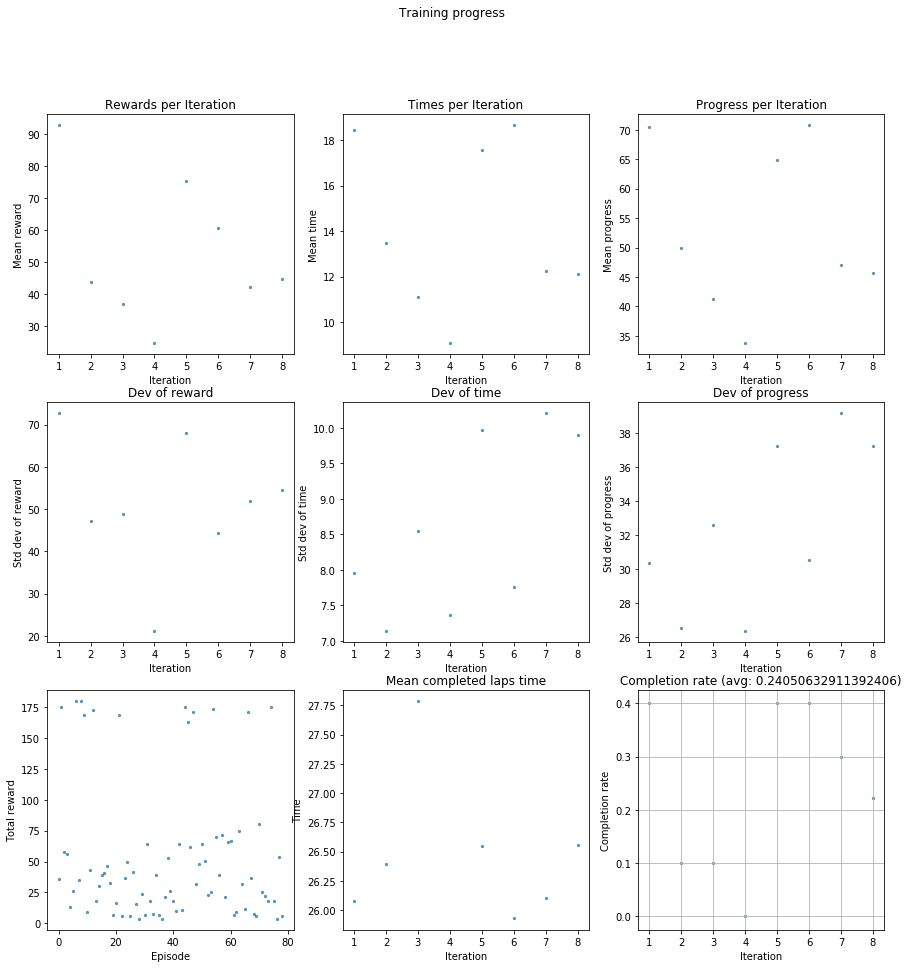

<Figure size 432x288 with 0 Axes>

In [57]:
simulation_agg = la.simulation_agg(df)

la.analyze_training_progress(simulation_agg, title='Training progress')

### Stats for all laps

Previous graphs were mainly focused on the state of training with regards to training progress. This however will not give you a lot of information about how well your reward function is doing overall.

In such case `scatter_aggregates` may come handy. It comes with three types of graphs:
* progress/steps/reward depending on the time of an episode - of this I find reward/time and new_reward/time especially useful to see that I am rewarding good behaviours - I expect the reward to time scatter to look roughly triangular
* histograms of time and progress - for all episodes the progress one is usually quite handy to get an idea of model's stability
* progress/time_if_complete/reward to closest waypoint at start - these are really useful during training as they show potentially problematic spots on track. It can turn out that a car gets best reward (and performance) starting at a point that just cannot be reached if the car starts elsewhere, or that there is a section of a track that the car struggles to get past and perhaps it's caused by an aggressive action space or undesirable behaviour prior to that place

Side note: `time_if_complete` is not very accurate and will almost always look better for episodes closer to 100% progress than in case of those 50% and below.

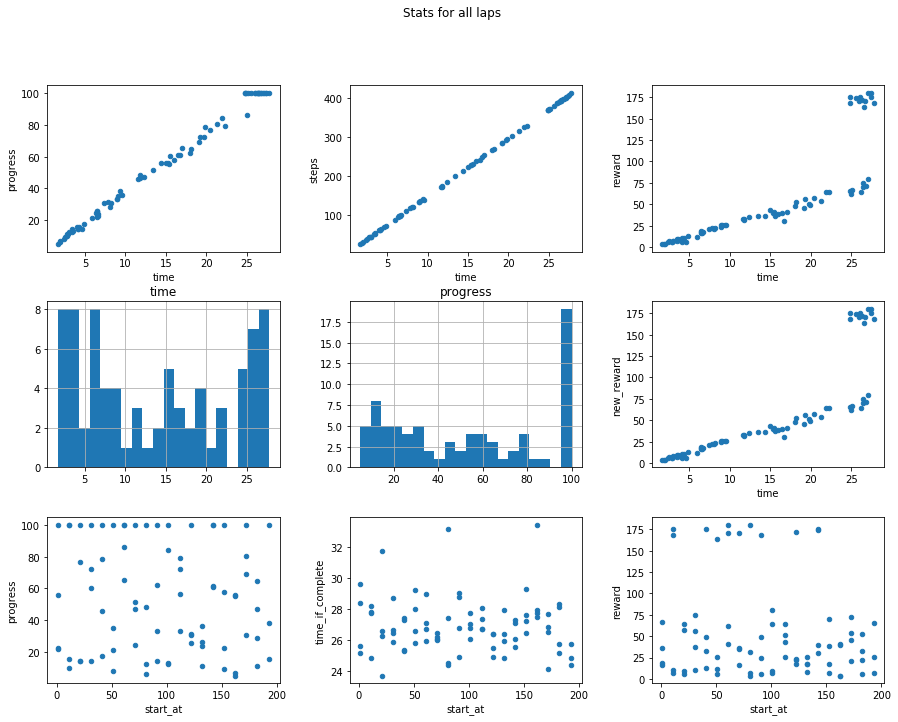

<Figure size 432x288 with 0 Axes>

In [58]:
# This gives the warning about ptp method deprecation. The code looks as if np.ptp was used, I don't know how to fix it.
la.scatter_aggregates(simulation_agg, 'Stats for all laps')

### Stats for complete laps
The graphs here are same as above, but now I am interested in other type of information:
* does the reward scatter show higher rewards for lower completion times? If I give higher reward for a slower lap it might suggest that I am training the car to go slow
* what does the time histogram look like? With enough samples available the histogram takes a normal distribution graph shape. The lower the mean value, the better the chance to complete a fast lap consistently. The longer the tails, the greater the chance of getting lucky in submissions
* is the car completing laps around the place where the race lap starts? Or does it only succeed if it starts in a place different to the racing one?

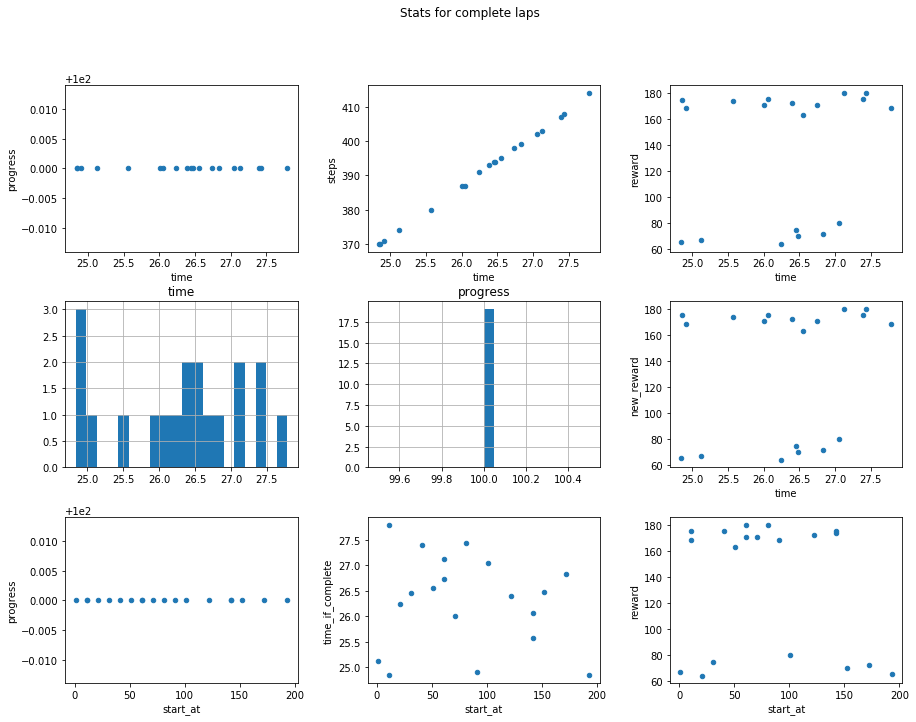

<Figure size 432x288 with 0 Axes>

In [59]:
complete_ones = simulation_agg[simulation_agg['progress']==100]

if complete_ones.shape[0] > 0:
    la.scatter_aggregates(complete_ones, 'Stats for complete laps')
else:
    print('No complete laps yet.')

### Categories analysis
We're going back to comparing training results based on the training time, but in a different way. Instead of just scattering things in relation to iteration or episode number, this time we're grouping episodes based on a certaing information. For this we use function:
```
analyze_categories(panda, category='quintile', groupcount=5, title=None)
```
The idea is pretty simple - determine a way to cluster the data and provide that as the `category` parameter (alongside the count of groups available). In the default case we take advantage of the aggregated information to which quintile an episode belongs and thus build buckets each containing 20% of episodes which happened around the same time during the training. If your training lasted for five hours, this would show results grouped per each hour.

A side note: if you run the function with `category='start_at'` and `groupcount=20` you will get results based on the waypoint closest to the starting point of an episode. If you need to, you can introduce other types of categories and reuse the function.

The graphs are similar to what we've seen above. I especially like the progress one which shows where the model tends to struggle and whether it's successful laps rate is improving or beginning to decrease. Interestingly, I also had cases where I saw the completion drop on the progress rate only to improve in a later quintile, but with a better time graph.

A second side note: if you run this function for `complete_ones` instead of `simulation_agg`, suddenly the time histogram becomes more interesting as you can see whether completion times improve.

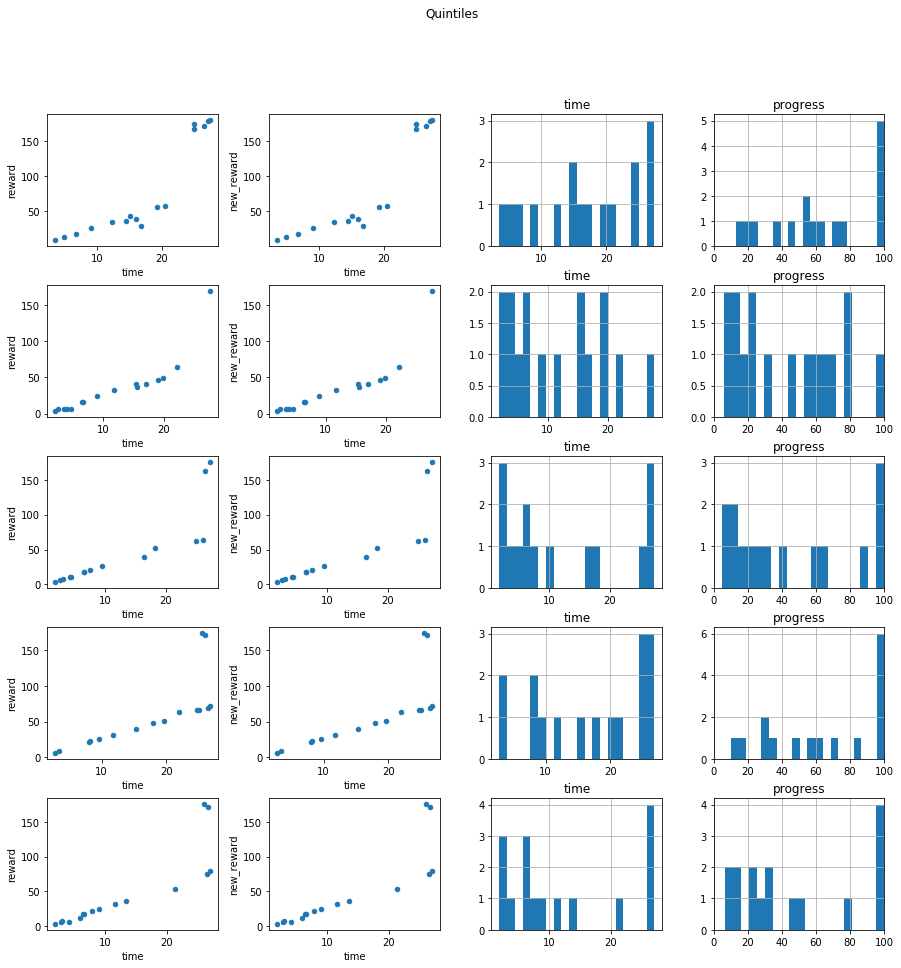

<Figure size 432x288 with 0 Axes>

In [60]:
la.analyze_categories(simulation_agg, title='Quintiles')

## Data in tables

While a lot can be seen in graphs that cannot be seen in the raw numbers, the numbers let us get into more detail. Below you will find a couple examples. If your model is behaving the way you would like it to, below tables may provide little added value, but if you struggle to improve your car's performance, they may come handy. In such cases I look for examples where high reward is giving to below-expected episode and when good episodes are given low reward.

You can then take the episode number and scatter it below, and also look at reward given per step - this can in turn draw your attention to some rewarding anomalies and help you detect some unexpected outcomes in your reward function.

There is a number of ways to select the data for display:
* `nlargest`/`nsmallest` lets you display information based on a specific value being highest or lowest
* filtering based on a field value, for instance `df[df['episode']==10]` will display only those steps in `df` which belong to episode 10
* `head()` lets you peek into a dataframe

There isn't a right set of tables to display here and the ones below may not suit your needs. Get to know Pandas more and have fun with them. It's almost as addictive as DeepRacer itself.

The examples have a short comment next to them explaining what they are showing.

In [12]:
# View ten best rewarded episodes in the training
simulation_agg.nlargest(10, 'new_reward')

,iteration,episode,steps,start_at,progress,time,new_reward,throttle,reward,time_if_complete,reward_if_complete,quintile,complete
33,2,33,436,132,100.0,29.337322,561.8640,2.673913,561.8640,29.337322,561.8640,2nd,1
60,4,60,406,1,100.0,27.291143,561.3065,2.753071,561.3065,27.291143,561.3065,3rd,1
55,3,55,397,152,100.0,26.647765,560.9500,2.845477,560.9500,26.647765,560.9500,3rd,1
67,4,67,420,71,100.0,28.275555,558.8190,2.668646,558.8190,28.275555,558.8190,3rd,1
46,3,46,434,61,100.0,29.159980,555.6050,2.700000,555.6050,29.159981,555.6050,3rd,1
97,5,97,407,172,100.0,27.374176,549.7500,2.812500,549.7500,27.374176,549.7500,5th,1
56,3,56,431,162,100.0,28.949217,549.5690,2.760417,549.5690,28.949217,549.5690,3rd,1
108,6,108,392,81,100.0,26.394380,538.2500,2.763359,538.2500,26.394380,538.2500,5th,1
73,4,73,418,132,100.0,28.103179,534.6500,2.681384,534.6500,28.103179,534.6500,4th,1
1,1,1,412,11,100.0,27.752179,531.1690,2.836562,531.1690,27.752179,531.1690,1st,1


In [13]:
# View five fastest complete laps
complete_ones.nsmallest(5, 'time')

,iteration,episode,steps,start_at,progress,time,new_reward,throttle,reward,time_if_complete,reward_if_complete,quintile,complete
21,2,21,376,11,100.0,25.287877,384.026,2.932361,384.026,25.287877,384.026,1st,1
100,6,100,377,1,100.0,25.350714,488.912,2.849206,488.912,25.350714,488.912,5th,1
89,5,89,382,91,100.0,25.665394,445.095,2.831593,445.095,25.665394,445.095,4th,1
58,3,58,382,182,100.0,25.695432,457.144,2.898172,457.144,25.695432,457.144,3rd,1
101,6,101,383,11,100.0,25.757904,527.121,2.863281,527.121,25.757904,527.121,5th,1


In [14]:
# View five best rewarded completed laps
complete_ones.nlargest(5, 'reward')

,iteration,episode,steps,start_at,progress,time,new_reward,throttle,reward,time_if_complete,reward_if_complete,quintile,complete
33,2,33,436,132,100.0,29.337322,561.8640,2.673913,561.8640,29.337322,561.8640,2nd,1
60,4,60,406,1,100.0,27.291143,561.3065,2.753071,561.3065,27.291143,561.3065,3rd,1
55,3,55,397,152,100.0,26.647765,560.9500,2.845477,560.9500,26.647765,560.9500,3rd,1
67,4,67,420,71,100.0,28.275555,558.8190,2.668646,558.8190,28.275555,558.8190,3rd,1
46,3,46,434,61,100.0,29.159980,555.6050,2.700000,555.6050,29.159981,555.6050,3rd,1


In [15]:
# View five best rewarded in completed laps (according to new_reward if you are using it)
complete_ones.nlargest(5, 'new_reward')

,iteration,episode,steps,start_at,progress,time,new_reward,throttle,reward,time_if_complete,reward_if_complete,quintile,complete
33,2,33,436,132,100.0,29.337322,561.8640,2.673913,561.8640,29.337322,561.8640,2nd,1
60,4,60,406,1,100.0,27.291143,561.3065,2.753071,561.3065,27.291143,561.3065,3rd,1
55,3,55,397,152,100.0,26.647765,560.9500,2.845477,560.9500,26.647765,560.9500,3rd,1
67,4,67,420,71,100.0,28.275555,558.8190,2.668646,558.8190,28.275555,558.8190,3rd,1
46,3,46,434,61,100.0,29.159980,555.6050,2.700000,555.6050,29.159981,555.6050,3rd,1


In [16]:
# View five most progressed episodes
simulation_agg.nlargest(5, 'progress')

,iteration,episode,steps,start_at,progress,time,new_reward,throttle,reward,time_if_complete,reward_if_complete,quintile,complete
0,1,0,400,1,100.0,26.857272,463.051,2.846633,463.051,26.857272,463.051,1st,1
1,1,1,412,11,100.0,27.752179,531.169,2.836562,531.169,27.752179,531.169,1st,1
7,1,7,389,71,100.0,26.084512,496.222,2.838462,496.222,26.084512,496.222,1st,1
8,1,8,401,81,100.0,26.913885,467.447,2.854478,467.447,26.913885,467.447,1st,1
9,1,9,386,91,100.0,26.033760,481.478,2.934109,481.478,26.033760,481.478,1st,1


In [17]:
# View information for a couple first episodes
simulation_agg.head()

,iteration,episode,steps,start_at,progress,time,new_reward,throttle,reward,time_if_complete,reward_if_complete,quintile,complete
0,1,0,400,1,100.0000,26.857272,463.051,2.846633,463.051,26.857272,463.051000,1st,1
1,1,1,412,11,100.0000,27.752179,531.169,2.836562,531.169,27.752179,531.169000,1st,1
2,1,2,57,21,12.5669,3.830023,78.508,2.663793,78.508,30.477073,624.720496,1st,0
3,1,3,81,31,20.2970,5.429581,90.115,2.780488,90.115,26.750659,443.981869,1st,0
4,1,4,107,41,29.7720,7.177664,127.010,2.958333,127.010,24.108774,426.608894,1st,0


In [18]:
# Set maximum quantity of rows to view for a dataframe display - without that
# the view below will just hide some of the steps
pd.set_option('display.max_rows', 500)

# View all steps data for episode 10
df[df['episode']==160]

,iteration,episode,steps,x,y,yaw,steer,throttle,action,reward,done,on_track,progress,closest_waypoint,track_len,timestamp,new_reward


## Analyze the reward distribution for your reward function

In [19]:
# This shows a histogram of actions per closest waypoint for episode 771.
# Will let you spot potentially problematic places in reward granting.
# In this example reward function is clearly `return 1`. It may be worrying
# if your reward function has some logic in it.
# If you have a final step reward that makes the rest of this histogram
# unreadable, you can filter the last step out by using
# `episode[:-1].plot.bar` instead of `episode.plot.bar`
episode = df[df['episode']== 160]
episode.plot.bar(x='closest_waypoint', y='reward')

TypeError: no numeric data to plot

### Path taken for top reward iterations

NOTE: at some point in a single episode the car could go around multiple laps, the episode was terminated when car completed 1000 steps. Currently one episode has at most one lap. This explains why you can see multiple laps in an episode plotted below.

Being able to plot the car's route in an episode can help you detect certain patterns in its behaviours and either promote them more or train away from them. While being able to watch the car go in the training gives some information, being able to reproduce it after the training is much more practical.

Graphs below give you a chance to look deeper into your car's behaviour on track.

In [ ]:
# Fetch information about the car's episodes and plot some of them
action_map, episode_map, sorted_idx = la.episode_parser(data)

# There is a trick that lets you view top episodes based on different criteria
# than the ones returned from the `episode_parser` function. Some examples:
# highest reward for complete laps:
sorted_idx = list(complete_ones.nlargest(3,'reward')['episode'])
# highest progress from all episodes:
sorted_idx = list(simulation_agg.nlargest(3,'progress')['episode'])

fig = la.plot_top_laps(sorted_idx[:],  episode_map, l_center_line, l_inner_border, l_outer_border, 3)

In [ ]:
## Evaluation RUN
def plot_episode_run(df, E, center_line, inner_border, outer_border):
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(211)
    la.print_border(ax, center_line, inner_border, outer_border) 
    episode_data = df[df['episode'] == E]
    for row in episode_data.iterrows():
        x1,y1,action,reward = row[1]['x'], row[1]['y'], row[1]['action'], row[1]['reward']
        car_x2, car_y2 = x1 - 0.02, y1
        plt.plot([x1, car_x2], [y1, car_y2], 'r.')

### Path taken in a particular Episode

In [ ]:
plot_episode_run(df, 160, l_center_line, l_inner_border, l_outer_border) # arbitrary episode

### Path taken in a particular Iteration

In [ ]:
iteration_id = 8

for i in range((iteration_id-1)*EPISODES_PER_ITERATION, (iteration_id)*EPISODES_PER_ITERATION):
    plot_episode_run(df, i, l_center_line, l_inner_border, l_outer_border)